In [228]:
import pandas as pd
import sqlite3
import json
import numpy as np
import matplotlib.pyplot as plt

Get how much AI is relevant in the ability.

In [249]:
filename = 'AIOE_DataAppendix.xlsx'
ai_exposure = pd.read_excel(filename, sheet_name=5, index_col=0)
ai_exposure['Overall'] = ai_exposure.sum(axis=1)
# Rename one index from Visual Color Determination to Visual Color Discrimination
ai_exposure.rename(index={'Visual Color Determination' : 'Visual Color Discrimination'}, inplace=True)
overall_ai_exposure = dict(zip(ai_exposure.index, ai_exposure['Overall']))

For each job (which would have a code), get the corresponding prevalence and importance of the job as per the O*NET database. 

In [253]:
# Get the data dictionary so that we can name the abilities and not deal with codes
filename = 'Content Model Reference.xlsx'
data_dict_df = pd.read_excel(filename)
data_dict = dict(zip(data_dict_df['Element ID'], data_dict_df['Element Name']))

conn = sqlite3.connect('abilities.db')
abilities_df = pd.read_sql('SELECT * FROM abilities', conn)
abilities_df['SOC'] = abilities_df['onetsoc_code'].apply(lambda x : x[:7])
abilities_df['ability'] = abilities_df['element_id'].apply(lambda x : data_dict[x])

# Make sure date is in datetime format
abilities_df['date_updated'] = pd.to_datetime(abilities_df['date_updated'])

# Keep the latest date for each SOC × ability, but preserve first-seen order
abilities_df = (
    abilities_df
    .sort_values('date_updated')  # oldest → newest
    .drop_duplicates(
        subset=['SOC', 'ability', 'scale_id'], 
        keep='last'                # keep the most recent
    )
    .sort_index()  # restore original row order formatting
)

In [258]:
# for SOC code, get the element_id
soc_dict = {}

for _, row in abilities_df.iterrows():
    soc = row['SOC']
    ability = row['ability']
    scale = row['scale_id']
    score = row['data_value']

    # make sure structure exists
    if soc not in soc_dict:
        soc_dict[soc] = {}
    if ability not in soc_dict[soc]:
        soc_dict[soc][ability] = {}

    # assign score
    soc_dict[soc][ability][scale] = score

    # Add the AI score. We can do this repeatedly because it won't rlly change.
    scale='A'
    soc_dict[soc][ability][scale] = overall_ai_exposure[ability]

Now, we can get the AIOE for each SOC code

In [260]:
soc_aioe = {}
for soc, abilities in soc_dict.items():
    weight = 0
    ai_weight = 0
    for ability in abilities.values():
        importance = ability['IM']
        ai = ability['A']
        prevalence = ability['LV']

        weight += importance * prevalence
        ai_weight += ai * importance * prevalence
    soc_aioe[soc] = ai_weight/weight
        

In [264]:
abilities_df['AIOE'] = abilities_df['SOC'].apply(lambda x : soc_aioe[x])
abilities_df

,onetsoc_code,element_id,scale_id,data_value,n,standard_error,lower_ci_bound,upper_ci_bound,recommend_suppress,not_relevant,date_updated,domain_source,SOC,ability,AIOE
0,11-1011.00,1.A.1.a.1,IM,4.62,8,0.1830,4.2664,4.9836,N,None,2023-08-01,Analyst,11-1011,Oral Comprehension,0.694400
1,11-1011.00,1.A.1.a.1,LV,4.88,8,0.1250,4.6300,5.1200,N,N,2023-08-01,Analyst,11-1011,Oral Comprehension,0.694400
2,11-1011.00,1.A.1.a.2,IM,4.25,8,0.1637,3.9292,4.5708,N,None,2023-08-01,Analyst,11-1011,Written Comprehension,0.694400
3,11-1011.00,1.A.1.a.2,LV,4.88,8,0.1250,4.6300,5.1200,N,N,2023-08-01,Analyst,11-1011,Written Comprehension,0.694400
4,11-1011.00,1.A.1.a.3,IM,4.50,8,0.1890,4.1296,4.8704,N,None,2023-08-01,Analyst,11-1011,Oral Expression,0.694400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92971,53-7121.00,1.A.4.b.3,LV,2.00,8,0.0000,2.0000,2.0000,N,N,2019-08-01,Analyst,53-7121,Sound Localization,-0.016167
92972,53-7121.00,1.A.4.b.4,IM,3.12,8,0.1250,2.8800,3.3700,N,None,2019-08-01,Analyst,53-7121,Speech Recognition,-0.016167
92973,53-7121.00,1.A.4.b.4,LV,2.75,8,0.1637,2.4292,3.0708,N,N,2019-08-01,Analyst,53-7121,Speech Recognition,-0.016167
92974,53-7121.00,1.A.4.b.5,IM,3.12,8,0.1250,2.8800,3.3700,N,None,2019-08-01,Analyst,53-7121,Speech Clarity,-0.016167


To have a sanity check, we need to be sure that histogram from the Excel File that they Felten et al. gave us does not differ from ours. There will be differences in our AIOE scores because O*NET updates the prevalence and importance of jobs, but overall, the shape should stay the same. Here is a histogram of Felten et al. and also our distribution of AIOE scores.
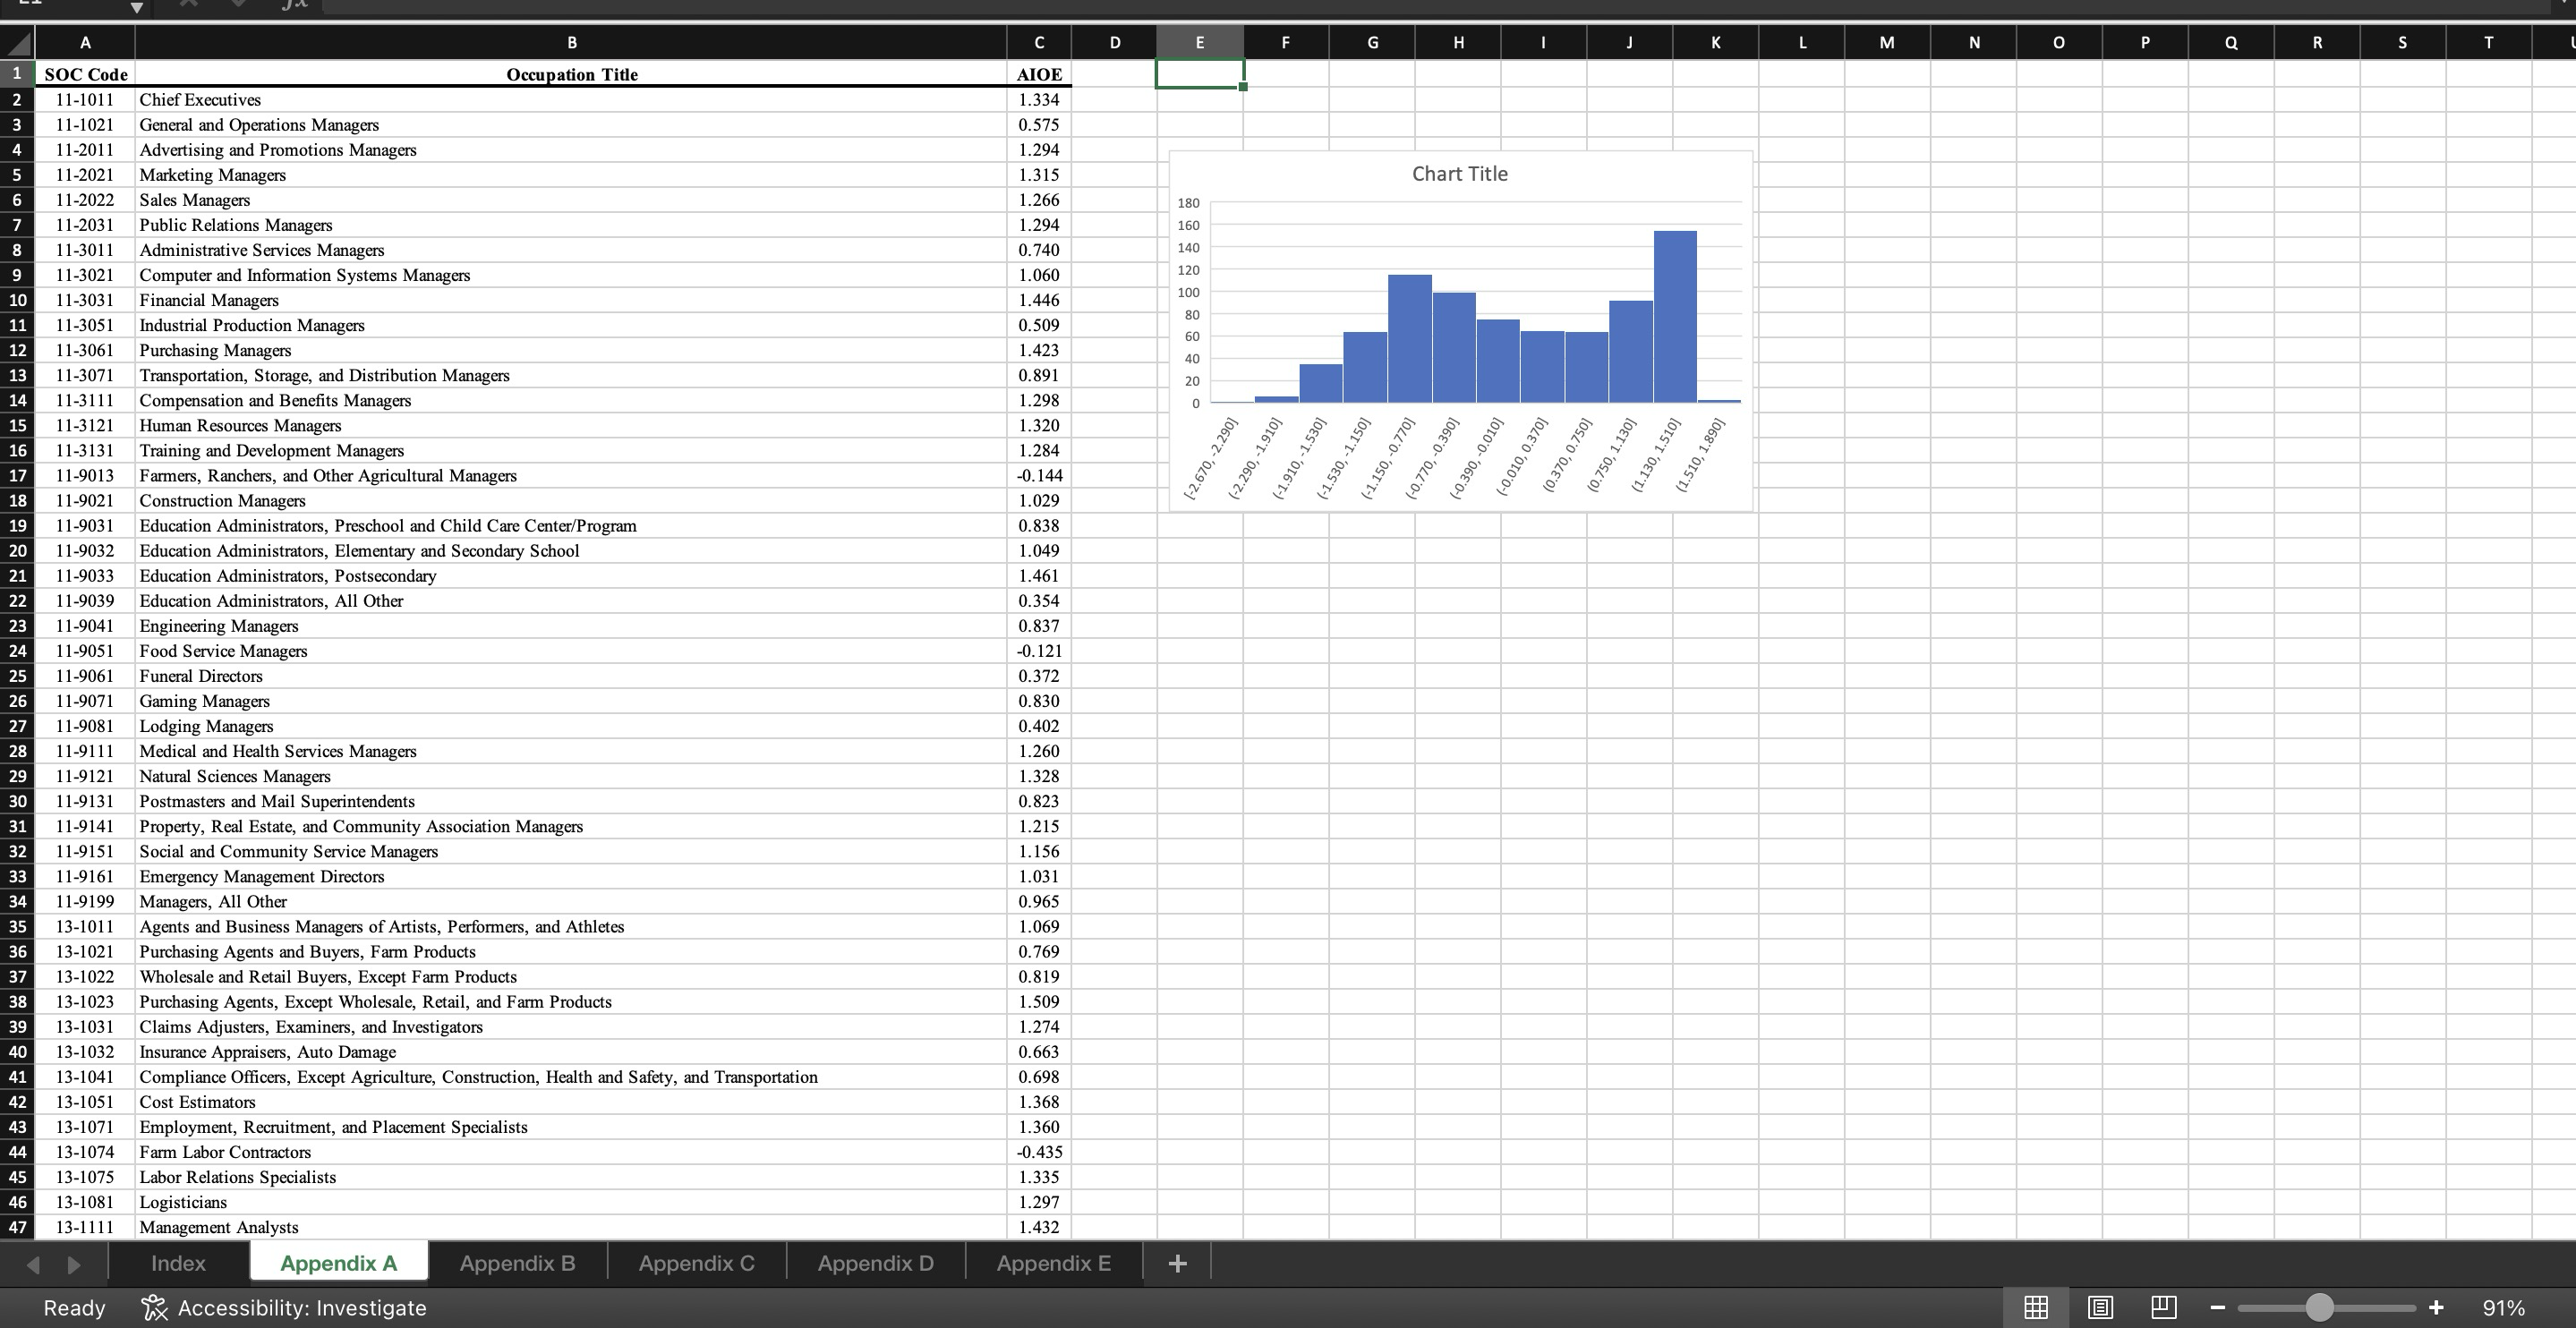

(array([  1.,  13.,  43., 100., 128.,  88.,  81.,  62., 108., 150.]),
 array([-2.67015939, -2.24581669, -1.821474  , -1.3971313 , -0.9727886 ,
        -0.54844591, -0.12410321,  0.30023949,  0.72458218,  1.14892488,
         1.57326757]),
 <BarContainer object of 10 artists>)

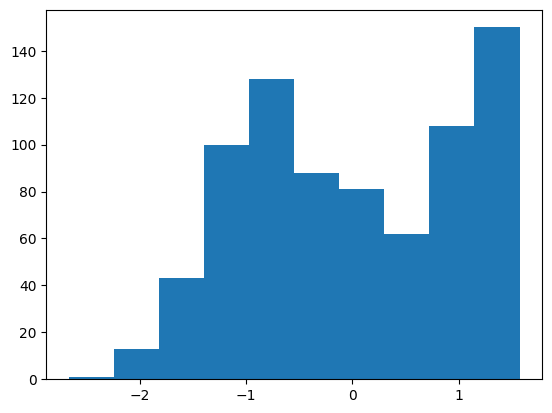

In [279]:
aioe_scores = np.array(list(soc_aioe.values()))
plt.hist((aioe_scores - aioe_scores.mean()) / aioe_scores.std())

# Mapping Philippine Jobs to their AIOE Scores

In [406]:
filename = '../1_crosswalk_mca_soc/mca_soc.csv'
mca_df = pd.read_csv(filename)

For some reason, we are using the old SOC code, so we have to update it. This is just based on old iterations where we checked which codes did not map to the O*NET database. Then we manually checked for each one and find if there exists a new version.

In [407]:
old_to_new = {
    "15-1151": "15-1232",
    "19-4093": "19-4071",
    "15-1199": "15-1299",
    "15-1141": "15-1242",
    "51-9122": "51-9124",
    "15-1134": "15-1254",
    "53-7032": "47-5022",
    "31-1014": "31-1131",
    "25-9011": "25-9011",
    "43-9011": "15-1299",
    "29-1069": "29-1229",
    "53-7033": "47-5044",
    "29-9011": "19-5011",
    "15-1121": "15-1211",
    "15-1152": "15-1231",
    "15-1142": "15-1244",
    "19-4091": "19-4042",
    "47-5031": "47-5032",
    "45-3021": "45-3031",
    "51-4012": "51-9162"
}

mca_df['SOC'] = mca_df['SOC'].replace(old_to_new)

Now, you can map from the SOC code to the AIOE

In [408]:
mca_df['AIOE'] = mca_df['SOC'].apply(lambda x : soc_aioe.get(x.strip(), np.nan))

In [414]:
mca_df['major_minor'] = mca_df['SOC'].str[:2]
mca_df['AIOE'] = mca_df['AIOE'].fillna(
    mca_df.groupby('major_minor')['AIOE'].transform('median')
)

In [415]:
mca_df.isnull().sum() / mca_df.shape[0]

Job Title                                                 0.0
Job Sector                                                0.0
Job Subsector                                             0.0
Educational Pathway                                       0.0
HEI with PRC (Professional Regulation Commission) Exam    0.0
Some HEI                                                  0.0
PSOC                                                      0.0
ISCO                                                      0.0
SOC                                                       0.0
AIOE                                                      0.0
major_minor                                               0.0
dtype: float64

<Axes: >

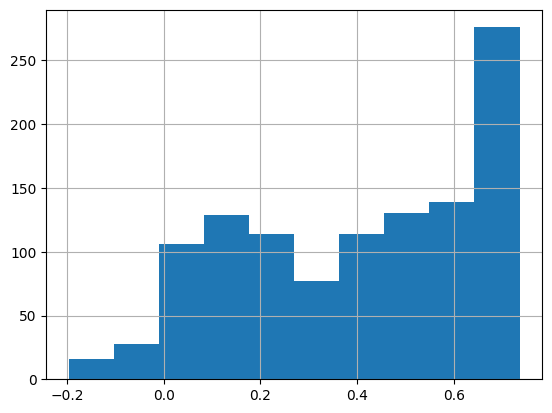

In [418]:
mca_df['AIOE'].hist()

In [419]:
mca_df.to_csv('soc_aioe.csv')